For this project, we decided to use google colab pro.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Downloading data

Due to the unavailability of data, we resorted to webscraping to obtain the data from the web. To proceed, we decided to use a python package called jmd_imagescraper, which we used to download images with black and white faces in different directories;

The training directory contains 150 images for training and the evaluation or test with 50 images.

In [2]:
!pip install -q jmd_imagescraper

In [3]:
root1="/content/drive/MyDrive/Colab Notebooks/neveda_test/"

In [6]:
from pathlib import Path
#root = Path().cwd()/"images"
root = root1 +"ct"
from jmd_imagescraper.core import * # dont't worry, it's designed to work with import *

duckduckgo_search(root, "clearwhite", "coloured images of white man faces", max_results=100)
duckduckgo_search(root, "clearblack", "coloured images of Black man faces", max_results=100)

Duckduckgo search: coloured images of white man faces


Duckduckgo search: coloured images of Black man faces


[PosixPath('/content/drive/MyDrive/Colab Notebooks/neveda_test/ct/clearblack/087_b32d220c.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/neveda_test/ct/clearblack/088_e5853798.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/neveda_test/ct/clearblack/089_c1059e79.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/neveda_test/ct/clearblack/090_81d5fc92.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/neveda_test/ct/clearblack/091_53bd62e7.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/neveda_test/ct/clearblack/092_7d29053e.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/neveda_test/ct/clearblack/093_e50ac3c1.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/neveda_test/ct/clearblack/094_89a2d8e2.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/neveda_test/ct/clearblack/095_d2d216f3.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/neveda_test/ct/clearblack/096_302dee53.jpg'),
 PosixPath('/content/drive/MyD

In [7]:
ls "/content/drive/MyDrive/neveda_test/neveda_test/images/"

black/  white/


# Importing Modules

we will import the necessary packages that will be used for the development of our model and the prediction using it.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

# Creating the Model



In the next lines of code we  will utr hto build to vgg19 Model to train, the model with sample of images collected. Later on test in on sample of images

We'll also set the random seeds.

In [10]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Let's define the VGG base architecture.

In [11]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

Next up is calculating the features for each VGG configuration  for vgg19

In [12]:
vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']


We can now define a function which takes in a configuration list and returns a nn.Sequential with the respective layers.

In [13]:
def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

The original VGG paper didn't use batch normalization, but it is now common to use it in VGG models.

In [14]:
vgg19_layers = get_vgg_layers(vgg19_config, batch_norm=True)   

let's visualise the vgg_layer 

In [15]:
vgg19_layers 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [16]:
OUTPUT_DIM = 10

model = VGG(vgg19_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

We will use the pre-trained model 

In [17]:
import torchvision.models as models

pretrained_model = models.vgg19_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [19]:
pretrained_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [20]:
IN_FEATURES = pretrained_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [21]:
pretrained_model.classifier[-1] = final_fc

In [22]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


In [23]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

This model has considerably more parameters than the previous model, AlexNet - 128M compared to 23M

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 139,622,218 trainable parameters


We handle the resizing with the Resize transform, passing in the desired size. As the images are larger we can also get away with slightly higher rotations and crops within the RandomRotation and RandomCrop transforms. We pass the pre-trained mean and stds the same way we would pass our calculated means and transforms.

In [25]:
pretrained_size =[ 224,224]
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding=10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])




test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding=10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])



We'll load the data with our defined transforms.



In [26]:
train_dir="/content/drive/MyDrive/neveda_test/neveda_test/images"
valid_dir="/content/drive/MyDrive/neveda_test/neveda_test/val"
test_dir="/content/drive/MyDrive/neveda_test/neveda_test/eval"

In [27]:
train_data = datasets.ImageFolder (train_dir, transform = train_transforms)
#validation_data = datasets.ImageFolder (valid_dir, transform = validation_transforms)
test_data = datasets.ImageFolder (test_dir, transform = test_transforms)


In [34]:
VALID_RATIO = 0.8

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [35]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [36]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 216
Number of validation examples: 54
Number of testing examples: 200


We'll also plot out a few images to ensure the transformations look sensible - making sure to re-normalize our data so we can view it with the correct colors.

In [37]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image


def plot_images(images, labels, classes, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

As we can see, the larger images mean we can get away with larger amounts of rotation and cropping with the images still looking reasonable.

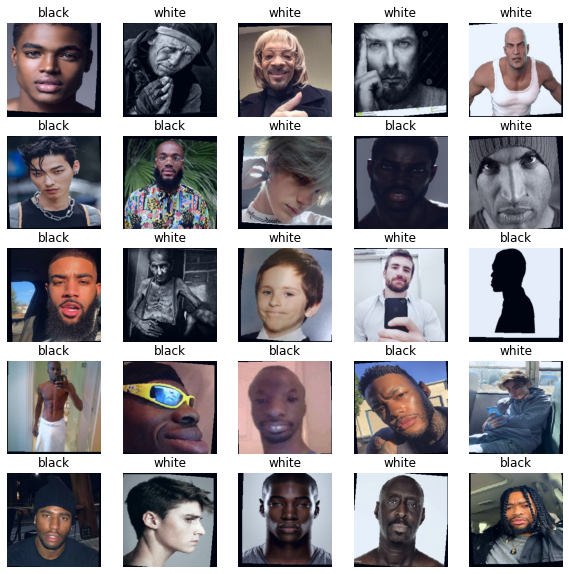

In [38]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [77]:
BATCH_SIZE =16

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

## Training the Model

Here we defined the parameter for the model  so as to train and optimised the modef for suitable learning for our algorithm.First we will find a suitable learning algorithm.


In [40]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [41]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred, _ = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in
                self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [42]:
import torch
torch.cuda.empty_cache()

we lauch the learning rate finder

In [43]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [44]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()


As we can see, the loss remains almost constant until around 
$5×10^{-4}$ it then decreases rapidly before diverging.

A good learning rate from this is the middle of the steep decline which is around $1×10^{-4}$


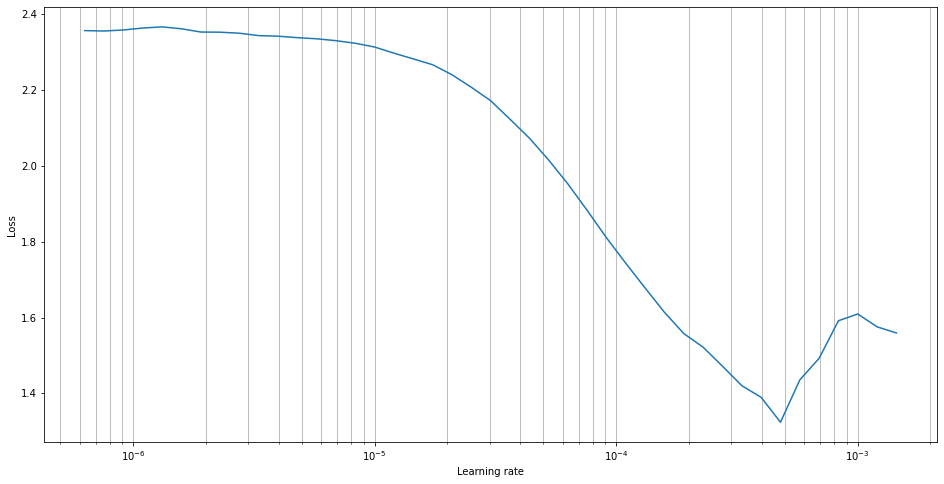

In [45]:
plot_lr_finder(lrs, losses, skip_start=10, skip_end=20)

We can now create an optimizer with our found learning rate and using discriminative fine-tuning.

The concept behind discriminative fine-tuning is that we use different learning rates for different layers in our models. The hypothesis is that early layers in a neural network learn to extract more general features, whilst later layers learn to extract more task specific features. If this is true, then the general features extracted by the early layers should be useful for any task, and we should change the pre-trained weights of them by a very small amount - if at all.

Note: discriminative fine-tuning should only be used when performing transfer learning from a pre-trained model. It is typically not necessary to use it when training a model from randomly initialized weights.


PyTorch allows us to set different learning rate values per parameter in our model. This is done by passing a list of dictionaries to the optimizer. Each dictionary should state the parameters ('params') and also any other arguments that will override those given directly to the optimizer.

Here, instead of using a different learning rate for every single layer, we have split the parameters into two "groups": features, which contains all the convolutional layers; and classifier, which contains all the linear layers. classifier will be using the FOUND_LR given directly to the optimizer and features will be using FOUND_LR / 10, as specified in the first dictionary. Thus, our convolutional layers have a learning rate 10x less than the linear layers.

In [47]:
FOUND_LR = 1e-4

params = [
          {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr=FOUND_LR)

Now all of the set-up is done, the rest of the notebook is pretty standard from here on out.

We create a function to calculate accuracy...

In [48]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

create a function that implements a training loop.

In [49]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [50]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [51]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model.

As our images have been resized to be significantly larger and our model has significantly more parameters training takes considerably longer. However, when performing transfer learning we usually train for significantly fewer epochs and are still able to achieve much higher accuracy than before.

We get ~94% validation accuracy in only five epochs.

In [52]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 0.895 | Train Acc: 65.18%
	 Val. Loss: 0.652 |  Val. Acc: 72.92%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.404 | Train Acc: 82.59%
	 Val. Loss: 0.851 |  Val. Acc: 76.04%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.214 | Train Acc: 90.18%
	 Val. Loss: 0.801 |  Val. Acc: 78.65%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.173 | Train Acc: 93.30%
	 Val. Loss: 0.943 |  Val. Acc: 76.04%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.108 | Train Acc: 96.88%
	 Val. Loss: 0.875 |  Val. Acc: 80.21%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.147 | Train Acc: 95.09%
	 Val. Loss: 0.936 |  Val. Acc: 75.00%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 0.062 | Train Acc: 98.21%
	 Val. Loss: 1.237 |  Val. Acc: 71.88%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.069 | Train Acc: 96.88%
	 Val. Loss: 1.664 |  Val. Acc: 74.48%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 0.101 | Train Acc: 95.98%
	 Val. Loss: 1.228 |  Val. Acc: 73.44%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 6s
	Train Loss: 0.052 | Train Acc: 97.77%
	 Val. Loss: 1.268 |  Val. Acc: 72.92%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 6s
	Train Loss: 0.076 | Train Acc: 97.32%
	 Val. Loss: 1.260 |  Val. Acc: 76.04%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 6s
	Train Loss: 0.066 | Train Acc: 98.21%
	 Val. Loss: 1.329 |  Val. Acc: 73.44%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 6s
	Train Loss: 0.053 | Train Acc: 97.32%
	 Val. Loss: 1.275 |  Val. Acc: 74.48%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 6s
	Train Loss: 0.050 | Train Acc: 97.77%
	 Val. Loss: 1.245 |  Val. Acc: 76.04%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 6s
	Train Loss: 0.079 | Train Acc: 98.21%
	 Val. Loss: 1.412 |  Val. Acc: 72.92%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 6s
	Train Loss: 0.045 | Train Acc: 97.32%
	 Val. Loss: 1.640 |  Val. Acc: 75.00%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 6s
	Train Loss: 0.028 | Train Acc: 99.11%
	 Val. Loss: 1.447 |  Val. Acc: 76.04%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 6s
	Train Loss: 0.040 | Train Acc: 99.11%
	 Val. Loss: 1.497 |  Val. Acc: 76.04%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 6s
	Train Loss: 0.054 | Train Acc: 97.77%
	 Val. Loss: 1.401 |  Val. Acc: 77.60%


Training:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 6s
	Train Loss: 0.014 | Train Acc: 99.55%
	 Val. Loss: 1.327 |  Val. Acc: 77.60%


In [53]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Test Loss: 0.527 | Test Acc: 77.40%


In [54]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [55]:

images, labels, probs = get_predictions(model, test_iterator)


  0%|          | 0/13 [00:00<?, ?it/s]

In [56]:

pred_labels = torch.argmax(probs, 1)

# Examining the Model

In [57]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)

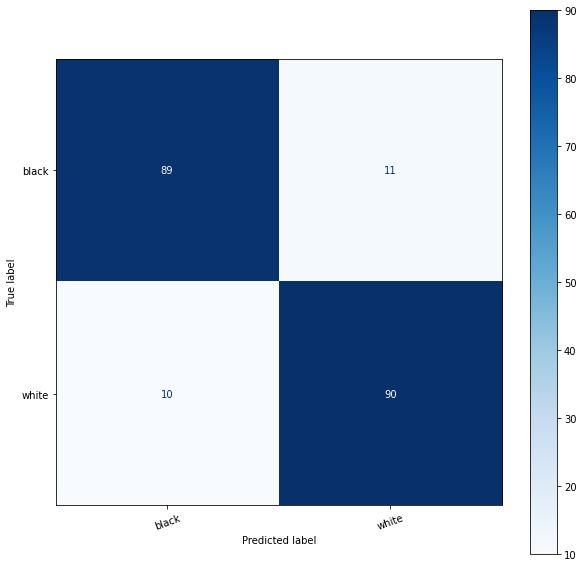

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

In [59]:
corrects = torch.eq(labels, pred_labels)

In [60]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [63]:
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

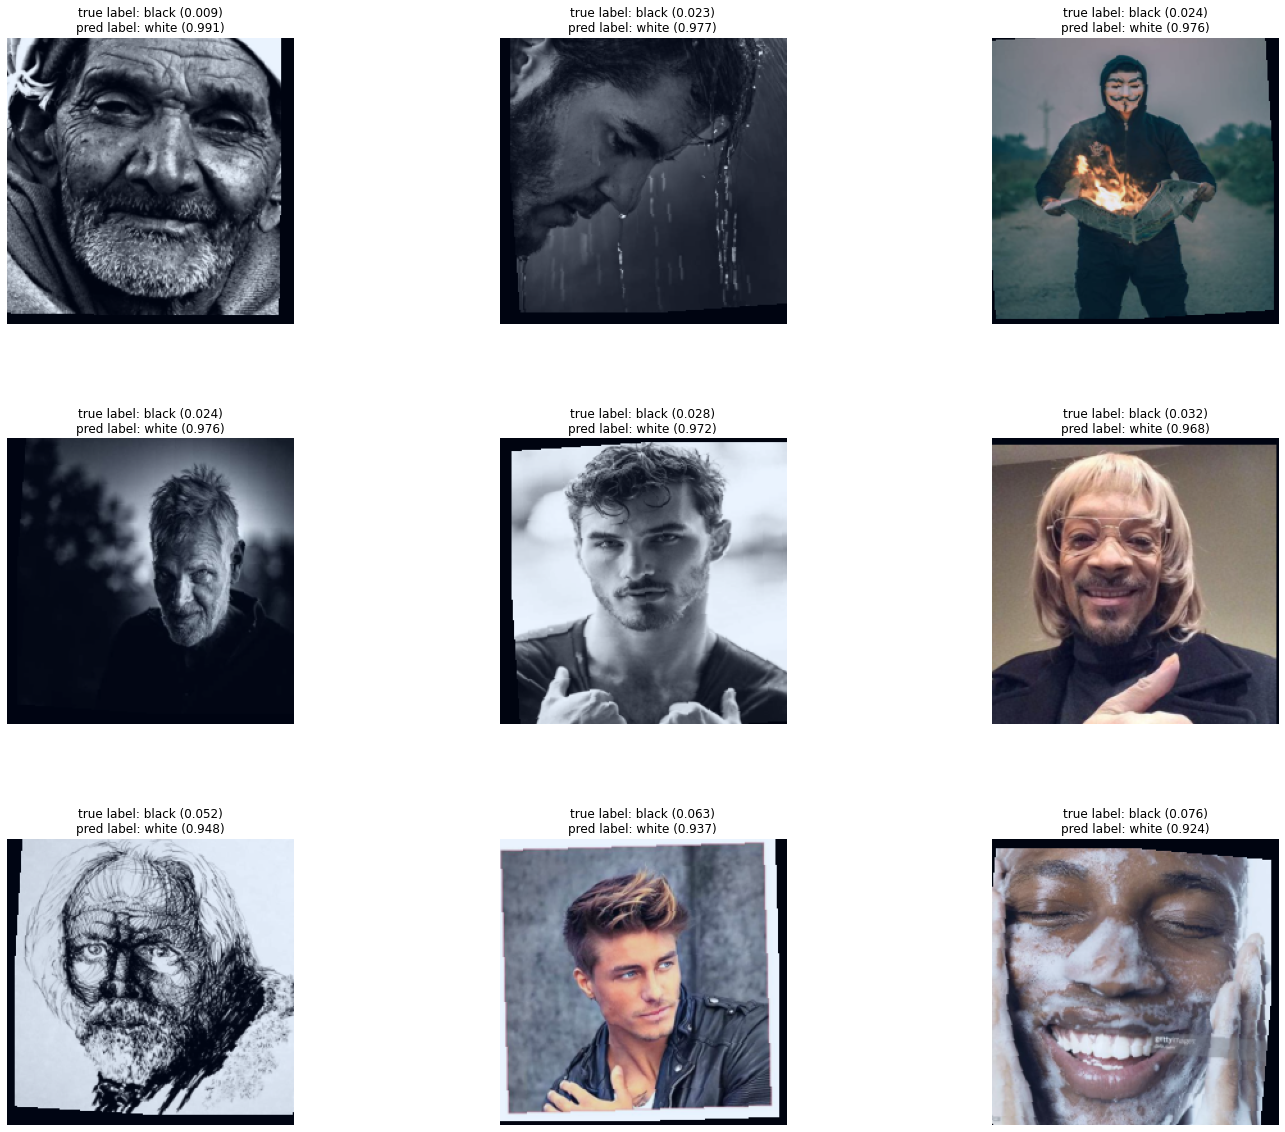

In [67]:
N_IMAGES = 12

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

Now test the images from the email we have the following results

In [70]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, _ = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, labels

In [71]:
outputs, labels = get_representations(model, train_iterator)

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
outputs

In [ ]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

We can then plot the PCA representations.

In [ ]:
def plot_representations(data, labels, classes, n_images=None):

    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=classes)

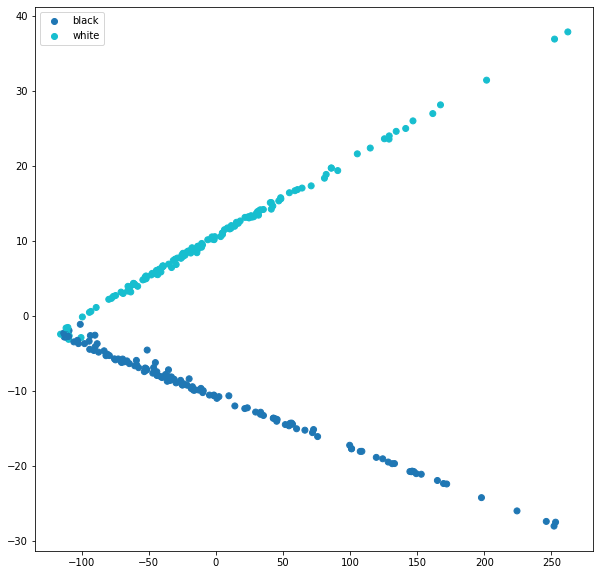

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)